# Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial - Inteligencia Artificial para Juegos (Game IA) - Sesión 4 - Tarea

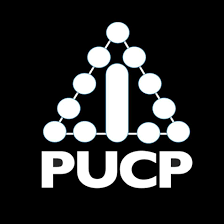
<img src='https://dci.pucp.edu.pe/wp-content/uploads/2014/02/logo-color-pucp1.gif' width=200px>

PhD. Edwin Villanueva, Eng. Daniel Saromo

<font color='orange'>Entorno de Connect Four (implementado como una variante del juego *k en raya*) para búsqueda adversarial en un juego de suma constante. Función ***k* en raya** implementada para $k > 1$ genérico.</font>

El presente notebook aborda el problema de busqueda adversarial en el juego Connect Four (ver figura). Este juego es una variante del juego k-en-raya (TicTacToe), donde el tamaño del tablero es de h=6 filas, v=7 columnas  y k=4 (gana el que haga primero 4 en raya). La diferencia con el clásico k-en-raya es que en Connect Four solo se permite movidas en los casilleros vacios más bajos de las columnas (como si las fichas fueran atraídas hacia abajo por la gravedad). El entorno de juego k-en-raya está implementado (clase TicTacToe). Están también implementados los algoritmos MINIMAX, ALPHA-BETA y Monte Carlo Tree Search que pueden ser llamados como jugadores. La clase `ConnectFour` implementa el entorno del juego Connect Four y hereda de la clase `TicTacToe`.

Sin embargo, el código está implementado de manera que las piezas "caen" horizontalmente hacia la izquierda, en lugar de verticalmente hacia abajo. El desafío de la semana consiste en implementar el método `actions` en la clase `ConnectFour_Vertical`, para que el entorno se comporte como el mostrado en la figura de abajo (donde las fichas a ser colocadas caen verticalmente hacia abajo).

<img src='https://upload.wikimedia.org/wikipedia/commons/a/ad/Connect_Four.gif' width=300px>

Considerar que las fichas del jugador MAX son **X**, mientas que las fichas del jugador MIN son **O**

El entorno del juego está completamente implementado, así como los algoritmos MINIMAX y ALPHA-BETA que pueden decidir movidas en el entorno virtual.

Recordar que en el algoritmo `minimax`, los valores altos de utilidad son buenos para el jugador MAX.

Considerar que las fichas del jugador MAX son **X**, mientas que las fichas del jugador MIN son **O**.

Completar con su código los campos requeridos y subir su notebook solucionado a la plataforma PAIDEIA. El formato del nombre del notebook es: `Desafio4_APELLIDOPATERNO_NOMBRE.ipynb`.

Es responsabilidad del alumno verificar que el archivo que subió es el correcto. Respetar los lineamientos de la entrega de archivo, ya que influirá en su calificación. La fecha límite de entrega del presente desafío se encuentra en PAIDEIA.

### Clase <b>Game</b>

Esta es una clase genérica para definir un entorno de juego. Es parecida a la clase `Problem` de búsqueda, pero en vez del método que devuelve el costo de camino se tiene un metodo que devuelve la utilidad de un jugador en un estado dado. También la funcion test de objetivo es reemplazada por un test de estado terminal (`terminal_test`). Para crear una clase de un juego específico se debe hacer una subclase de `Game` e implementar los métodos actions, `result`, `utility`, y `terminal_test`. El atributo `.initial` (estado inicial del juego) deberá ser inicializado en el constructor de la clase concreta. No editar esta clase `Game`.

In [2]:
class Game:

    def actions(self, state):
        """Retorna una lista de movidas permitidas en el estado actual state."""
        raise NotImplementedError

    def result(self, state, move):
        """Retorna el nuevo estado que resulta de hacer una movida move en el estado state."""
        raise NotImplementedError

    def utility(self, state, player):
        """Retorna el valor de utilidad para el jugador player en el estado terminal state."""
        raise NotImplementedError

    def terminal_test(self, state):
        """Retorna True si el estado state es un estado terminal del juego."""
        return not self.actions(state)

    def to_move(self, state):
        """Retorna el jugador que le toca jugar en el presente estado state."""
        return state.to_move

    def display(self, state):
        """Imprime o displaya el state."""
        print(state)

    def __repr__(self):
        return '<{}>'.format(self.__class__.__name__)

    def play_game(self, *players, verbose=True):
        """Controlador del juego:
        Llama alternadamente a cada jugador pasandole el estado actual del juego y ejecutando la movida retornada."""
        state = self.initial
        numJugada = 0
        while True:
            for player in players:
                move = player(self, state)
                mark_now = self.to_move(state)
                state = self.result(state, move)
                numJugada = numJugada + 1
                if verbose:
                  print("Jugada", numJugada, ": Turno del jugador", player.__name__, "(",mark_now,")")
                  self.display(state)
                  print("*************************************************")
                if self.terminal_test(state):
                    print("Jugada", numJugada, "(final): Turno del jugador", player.__name__, "(",mark_now,")")
                    self.display(state)
                    print("La utilidad del primer jugador (",self.to_move(self.initial),") fue: ")
                    #retorna utilidad del 1er jugador al acabar el juego
                    return self.utility(state, self.to_move(self.initial))

### Clase <b>TicTacToe</b>

Esta es una subclase de `Game` para definir el entorno del juego k en Raya (generalizacion de `TicTacToe`). Las dimensiones del tablero son definidas en el constructor (usando los argumentos: h=número de filas, v=número de columnas, k=número de elementos en raya para ganar). Primer jugador (Max) es 'X' y el otro jugador (Min) es 'O'. Un estado en este juego es una tupla (`GameState`) con los siguientes campos:
 - to_move: almacena el jugador que le toca jugar 
 - utility: almacena la utilidad del estado
 - board: almacena las posiciones ocupadas en el tablero en la forma de un dicccionario de entradas {(x, y): Player}, donde Player puede ser 'X' o 'O'
 - moves: almacena las movidas posibles a partir del estado en la forma de una lista de tuplas que representan posiciones (x, y) 

In [3]:
from collections import namedtuple
import random
import itertools
import copy

#Para este entorno, un estado es una tupla con nombres de campos (namedtuple)
GameState = namedtuple('GameState', 'to_move, utility, board, moves')

class TicTacToe(Game):
    
    def __init__(self, h=3, v=3, k=3):
        self.h = h
        self.v = v
        self.k = k

        assert k>2, "k debe ser mayor que dos!"
        assert k<=h, "k debe ser menor o igual que h"
        assert k<=v, "k debe ser menor o igual que v"

        moves = [(x, y) for x in range(1, h + 1)
                 for y in range(1, v + 1)]
        self.initial = GameState(to_move='X', utility=0, board={}, moves=moves)

    def actions(self, state):
        """Movidas legales son todas las posiciones aun sin marcar (el estado almacena las movidas legales)"""
        return state.moves

    def result(self, state, move):
        """Retorna el nuevo estado de hacer la movida move en el estado state ."""
        if move not in state.moves:
            return state  # Si es una movida ilegal retorna sin cambiar el estado
        board = state.board.copy()
        board[move] = state.to_move

        moves = list(state.moves)
        moves.remove(move)
        return GameState(to_move=('O' if state.to_move == 'X' else 'X'),
                         utility=self.compute_utility(board, move, state.to_move),
                         board=board, moves=moves)

    def utility(self, state, player):
        """Retorna la utilidad del player en estado terminal state; 1 si ganó, -1 si perdió, 0 empate."""
        return state.utility if player == 'X' else -state.utility

    def terminal_test(self, state):
        """Un estado es terminal si hay un ganador o no hay mas movidas posibles."""
        return state.utility != 0 or len(state.moves) == 0

    def display(self, state):
        board = state.board
        for x in range(1, self.h + 1):
            for y in range(1, self.v + 1):
                print(board.get((x, y), '.'), end=' ')
            print()

    def k_in_row(self, board, player, square, k): #Adaptado de https://github.com/aimacode/aima-python
        """Devuelve True, si el jugador con marca "player" tiene k piezas en una fila, desde la posición square."""
        def in_row(x, y, dx, dy): return 0 if board.get((x, y)) != player else 1 + in_row(x + dx, y + dy, dx, dy)
        return any(in_row(*square, dx, dy) + in_row(*square, -dx, -dy) - 1 >= k
                  for (dx, dy) in ((0, 1), (1, 0), (1, 1), (1, -1)))

    def compute_utility(self, board, move, player):
        """Retorna  1 si player='X'  ha llegado a estado terminal ganador con movida move, 
           Retorna -1 si player='O' ha llegado a estado terminal ganador con movida move; 
           Retornas 0 en cualquier otro caso"""
        #Cálculo de utilidad para el caso general (k>1)
        win = self.k_in_row(board, player, move, self.k)
        return 0 if not win else +1 if player == 'X' else -1

### Clase <b>ConnectFour</b>

Connect Four es una variante del juego TicTacToe, en el que solo puedes hacer un movimiento en la fila inferior, o en un casillero directamente encima de un casillero ocupado. Tradicionalmente jugado en un tablero de 7x6 y gana el que hace 4 en raya. Por velocidad de cómputo, se eligen los valores de h=4, v=4 y k=3.

In [46]:
class ConnectFour(TicTacToe):

    def __init__(self, h=6, v=7, k=4):    #(h=6, v=7, k=4)  # h=4, v=4, k=3
        TicTacToe.__init__(self, h, v, k)
        
    def actions(self, state):#En esta implementación, las piezas caen verticalmente hacia la izquierda!
        return [(x, y) for (x, y) in state.moves
                if y == 1 or (x, y - 1) in state.board]

### Algoritmo  <b>MIN-MAX</b>

Este algoritmo escoge una movida para el jugador de turno en un juego dado (game). El algoritmo obtiene recursivamente los valores minimax de los estados sucesores buscando en profundidad en el arbol de juego los estados terminales. De estos estados toma su valor de utilidad para calcular la utilidad de los padres y asi sucesivamente hasta tener la utilidad de todos los sucesores del estado inicial para decidir la movida a ejecutar. 
La implementacion de esta busqueda es a traves de una recursion alternada de las funciones max_value y min_value (una llama a la otra) hasta alcanzar un estado terminal. Cuando la recursion termina todas las movidas tienen una utilidad y se escoje la movida de mayor valor.


In [5]:
argmax = max
infinity = float('inf')

def minimax_decision(state, game):

    player = game.to_move(state)

    def max_value(state):
        if game.terminal_test(state):
            return game.utility(state, player)
        v = -infinity
        for a in game.actions(state):
            v = max(v, min_value(game.result(state, a)))
        return v

    def min_value(state):
        if game.terminal_test(state):
            return game.utility(state, player)
        v = infinity
        for a in game.actions(state):
            v = min(v, max_value(game.result(state, a)))
        return v

    # Body of minimax_decision:
    #Cuando la recursion termina todas las movidas tienen una
    #utilidad y se escoje la movida de mayor valor.
    return argmax(game.actions(state),
                  key=lambda a: min_value(game.result(state, a)))

### Algoritmo  <b>ALPHA-BETA</b>

Este algoritmo escoge una movida para el jugador de turno en el juego, evitando explorar las ramas que no son relevantes para tomar una decisión de movida en el estado actual. Alpha-Beta hace uso de las funciones max_value y min_value de MIN-MAX pero utilizando dos variables: alpha y betha. La variable apha mantiene la mejor opcion (la más alta utilidad) encontrada para MAX a lo largo del camino. La variable betha mantiene la mejor opcion (la más baja utilidad) encontrada para MIN. A medida que el algoritmo avanza se va actualizando alpha y betha y se poda un nodo cuando el valor del nodo es menor que el valor alpha (para MAX) o mayor que el valor betha (para MIN).

In [6]:
def alphabeta_search(state, game):
  
    player = game.to_move(state)

    # Functions used by alphabeta
    def max_value(state, alpha, beta):
        if game.terminal_test(state):
            return game.utility(state, player)
        v = -infinity
        for a in game.actions(state):
            v = max(v, min_value(game.result(state, a), alpha, beta))
            if v >= beta:
                return v
            alpha = max(alpha, v)
        return v

    def min_value(state, alpha, beta):
        if game.terminal_test(state):
            return game.utility(state, player)
        v = infinity
        for a in game.actions(state):
            v = min(v, max_value(game.result(state, a), alpha, beta))
            if v <= alpha:
                return v
            beta = min(beta, v)
        return v

    # Body of alphabeta_search:
    best_score = -infinity
    beta = infinity
    best_action = None
    for a in game.actions(state):
        v = min_value(game.result(state, a), best_score, beta)
        if v > best_score:
            best_score = v
            best_action = a
    return best_action

### Algoritmo  <b>Monte-Carlo Tree Search (MCTS)</b>


#### Implementa el nodo del arbol Monte carlo 

In [7]:
class MCT_Node:
    """Nodo del árbol de búsqueda Monte Carlo. Hace un seguimiento de los estados hijos (`children` states)."""

    def __init__(self, parent=None, state=None, U=0, N=0):
        self.__dict__.update(parent=parent, state=state, U=U, N=N)
        self.children = {}
        self.actions = None

#### Implementa la funcion UCB1 para la fase de selección

In [8]:
import numpy as np

def ucb(n, C=1.4):
    """Función UCB para la fase de selección."""
    if n.N == 0:
        return np.inf    
    else:
        return (n.U / n.N) + C * np.sqrt(np.log(n.parent.N) / n.N)

#### Algoritmo Monte-Carlo Tree Search

In [9]:
import random
def monte_carlo_tree_search(state, game, N=1000):
    def select(n):
        """Selecciona un leaf node en el árbol."""
        if n.children:
            return select(max(n.children.keys(), key=ucb))
        else:
            return n

    def expand(n):
        """Expande el leaf node agregando todos sus estados hijo (`children` states)."""
        if not n.children and not game.terminal_test(n.state):
            n.children = {MCT_Node(state=game.result(n.state, action), parent=n): action
                          for action in game.actions(n.state)}
        return select(n)

    def simulate(game, state):
        """Simula la utilidad del estado actual al tomar aleatoriamente un paso."""
        player = game.to_move(state)
        while not game.terminal_test(state):
            action = random.choice(list(game.actions(state)))
            state = game.result(state, action)
        v = game.utility(state, player)
        return -v

    def backprop(n, utility):
        """Pasa la utilidad a todos los nodos padre (es decir, hacia atrás)."""
        if utility > 0:
            n.U += utility
        # if utility == 0:
        #     n.U += 0.5
        n.N += 1
        if n.parent:
            backprop(n.parent, -utility)

    root = MCT_Node(state=state)

    for _ in range(N):
        leaf = select(root)
        child = expand(leaf)
        result = simulate(game, child.state)
        backprop(child, result)

    max_state = max(root.children, key=lambda p: p.N)

    return root.children.get(max_state)

### Jugadores </b>

A seguir se implementan 5 agentes jugadores que pueden hacer movidas en un entorno de juego, dado su estado :
- <b>minimax_player</b>:   jugador que hace movidas de acuerdo al algoritmo MIN-MAX
- <b>alphabeta_player</b>: jugador que hace movidas de acuerdo al algoritmo ALPHA-BETA
- <b>mcts_player</b>:    jugador que hace movidas de acuerdo al algoritmo MCTS
- <b>random_player</b>:    jugador que hace movidas aleatorias (es facil ganarle :v )
- <b>human_player</b>:     solicita la movida a un humano


In [10]:
def minimax_player(game, state):
    return minimax_decision(state, game)

def alphabeta_player(game, state):
    return alphabeta_search(state, game)

def mcts_player(game, state):
    return monte_carlo_tree_search(state, game)

def random_player(game, state):
    return random.choice(game.actions(state))

def human_player(game, state):
    print("Estado actual:")
    game.display(state)
    print("Movidas disponibles: {}".format(game.actions(state)))
    print("")
    move_string = input('Humano, ¿cuál es tu movida?')
    try:
        move = eval(move_string)
    except NameError:
        move = move_string
    return move

## Jugando

Considerar que, para el jugador humano, las coordenadas de la pieza que se desea colocar se ingresan como una tupla de dos elementos: `(fila, columna)`, cuya numeración inicia desde el 1.

Instancia juego `ConnectFour(h=4, v=5, k=3)` y llama al controlador de juego. 1er player=alphabeta, 2do player=random_player

In [47]:
cFour = ConnectFour(h=4, v=5, k=3)
print(cFour.play_game(alphabeta_player, random_player, verbose=True))

Jugada 1 : Turno del jugador alphabeta_player ( X )
. X . . . 
. . . . . 
. . . . . 
. . . . . 
*************************************************
Jugada 2 : Turno del jugador random_player ( O )
. X . O . 
. . . . . 
. . . . . 
. . . . . 
*************************************************
Jugada 3 : Turno del jugador alphabeta_player ( X )
. X X O . 
. . . . . 
. . . . . 
. . . . . 
*************************************************
Jugada 4 : Turno del jugador random_player ( O )
O X X O . 
. . . . . 
. . . . . 
. . . . . 
*************************************************
Jugada 5 : Turno del jugador alphabeta_player ( X )
O X X O . 
. X . . . 
. . . . . 
. . . . . 
*************************************************
Jugada 6 : Turno del jugador random_player ( O )
O X X O . 
. X O . . 
. . . . . 
. . . . . 
*************************************************
Jugada 7 : Turno del jugador alphabeta_player ( X )
O X X O . 
. X O . . 
. X . . . 
. . . . . 
*************************************

Instancia juego `ConnectFour(h=4, v=5, k=3)` y llama al controlador de juego. 1er player=mcst, 2do player=random_player

In [48]:
cFour = ConnectFour(h=4, v=5, k=3)
print(cFour.play_game(mcts_player, random_player, verbose=True))

Jugada 1 : Turno del jugador mcts_player ( X )
. . X . . 
. . . . . 
. . . . . 
. . . . . 
*************************************************
Jugada 2 : Turno del jugador random_player ( O )
. . X . O 
. . . . . 
. . . . . 
. . . . . 
*************************************************
Jugada 3 : Turno del jugador mcts_player ( X )
. X X . O 
. . . . . 
. . . . . 
. . . . . 
*************************************************
Jugada 4 : Turno del jugador random_player ( O )
. X X . O 
. O . . . 
. . . . . 
. . . . . 
*************************************************
Jugada 5 : Turno del jugador mcts_player ( X )
X X X . O 
. O . . . 
. . . . . 
. . . . . 
*************************************************
Jugada 5 (final): Turno del jugador mcts_player ( X )
X X X . O 
. O . . . 
. . . . . 
. . . . . 
La utilidad del primer jugador ( X ) fue: 
1


Instancia juego `ConnectFour(h=4, v=5, k=3)` y llama al controlador de juego. 1er player=mcst, 2do player=alphabeta

In [49]:
cFour = ConnectFour(h=4, v=5, k=3)
cFour.play_game(mcts_player, alphabeta_player, verbose=False)

Jugada 5 (final): Turno del jugador mcts_player ( X )
O O X X X 
. . . . . 
. . . . . 
. . . . . 
La utilidad del primer jugador ( X ) fue: 


1

In [50]:
cFour = ConnectFour(h=4, v=5, k=3)
print(cFour.play_game(mcts_player, alphabeta_player, verbose=True))

Jugada 1 : Turno del jugador mcts_player ( X )
. . X . . 
. . . . . 
. . . . . 
. . . . . 
*************************************************
Jugada 2 : Turno del jugador alphabeta_player ( O )
O . X . . 
. . . . . 
. . . . . 
. . . . . 
*************************************************
Jugada 3 : Turno del jugador mcts_player ( X )
O . X X . 
. . . . . 
. . . . . 
. . . . . 
*************************************************
Jugada 4 : Turno del jugador alphabeta_player ( O )
O O X X . 
. . . . . 
. . . . . 
. . . . . 
*************************************************
Jugada 5 : Turno del jugador mcts_player ( X )
O O X X X 
. . . . . 
. . . . . 
. . . . . 
*************************************************
Jugada 5 (final): Turno del jugador mcts_player ( X )
O O X X X 
. . . . . 
. . . . . 
. . . . . 
La utilidad del primer jugador ( X ) fue: 
1


Instancia juego `ConnectFour(h=4, v=5, k=3)` y llama al controlador de juego. 1er player=alphabeta, 2do player=human

In [15]:
cFour = ConnectFour(h=4, v=5, k=3)
print(cFour.play_game(alphabeta_player, human_player))

Jugada 1 : Turno del jugador alphabeta_player ( X )
X . . . . 
. . . . . 
. . . . . 
. . . . . 
*************************************************
Estado actual:
X . . . . 
. . . . . 
. . . . . 
. . . . . 
Movidas disponibles: [(1, 2), (2, 1), (3, 1), (4, 1)]

Humano, ¿cuál es tu movida?(2,1)
Jugada 2 : Turno del jugador human_player ( O )
X . . . . 
O . . . . 
. . . . . 
. . . . . 
*************************************************
Jugada 3 : Turno del jugador alphabeta_player ( X )
X X . . . 
O . . . . 
. . . . . 
. . . . . 
*************************************************
Estado actual:
X X . . . 
O . . . . 
. . . . . 
. . . . . 
Movidas disponibles: [(1, 3), (2, 2), (3, 1), (4, 1)]

Humano, ¿cuál es tu movida?(3,1)
Jugada 4 : Turno del jugador human_player ( O )
X X . . . 
O . . . . 
O . . . . 
. . . . . 
*************************************************
Jugada 5 : Turno del jugador alphabeta_player ( X )
X X X . . 
O . . . . 
O . . . . 
. . . . . 
**********************************

Instancia juego ConnectFour (h=4, v=5, k=3) y llama al controlador de juego. 1er player=mcst, 2do player=human

In [16]:
cFour = ConnectFour(h=4, v=5, k=3)
print(cFour.play_game(mcts_player, human_player ))

Jugada 1 : Turno del jugador mcts_player ( X )
. . . . . 
. . . . . 
X . . . . 
. . . . . 
*************************************************
Estado actual:
. . . . . 
. . . . . 
X . . . . 
. . . . . 
Movidas disponibles: [(1, 1), (2, 1), (3, 2), (4, 1)]

Humano, ¿cuál es tu movida?(4,1)
Jugada 2 : Turno del jugador human_player ( O )
. . . . . 
. . . . . 
X . . . . 
O . . . . 
*************************************************
Jugada 3 : Turno del jugador mcts_player ( X )
X . . . . 
. . . . . 
X . . . . 
O . . . . 
*************************************************
Estado actual:
X . . . . 
. . . . . 
X . . . . 
O . . . . 
Movidas disponibles: [(1, 2), (2, 1), (3, 2), (4, 2)]

Humano, ¿cuál es tu movida?(4,2)
Jugada 4 : Turno del jugador human_player ( O )
X . . . . 
. . . . . 
X . . . . 
O O . . . 
*************************************************
Jugada 5 : Turno del jugador mcts_player ( X )
X . . . . 
X . . . . 
X . . . . 
O O . . . 
*************************************************

## Desafío de la semana: Implementar la clase `ConnectFour_Vertical`

Como se mencionó anteriormente, en el entorno definido con la clase `ConnectFour`, las piezas "caen" horizontalmente hacia la izquierda, en lugar de verticalmente hacia abajo. El desafío de la semana consiste en implementar el método `actions` en la clase `ConnectFour_Vertical`.

El puntaje correspondiente al presente desafío es de 1 punto.

In [92]:
class ConnectFour_Vertical(TicTacToe):

    def __init__(self, h=6, v=7, k=4):  
        TicTacToe.__init__(self, h, v, k)
        
    def actions(self, state):
        return [(x, y) for (x, y) in state.moves
                if  x == 1 or (x-1, y) in state.board]              

In [93]:
#Con su función ya implementada, pruebe el entorno con un jugador MIMIMAX y con un jugador aleatorio.
cFour_Vertical = ConnectFour_Vertical(h=4, v=5, k=3)
#  print(cFour_Vertical.play_game(minimax_player, random_player, verbose=True))
print(cFour_Vertical.play_game(alphabeta_player, random_player, verbose=True))

Jugada 1 : Turno del jugador alphabeta_player ( X )
. X . . . 
. . . . . 
. . . . . 
. . . . . 
*************************************************
Jugada 2 : Turno del jugador random_player ( O )
. X . . O 
. . . . . 
. . . . . 
. . . . . 
*************************************************
Jugada 3 : Turno del jugador alphabeta_player ( X )
. X X . O 
. . . . . 
. . . . . 
. . . . . 
*************************************************
Jugada 4 : Turno del jugador random_player ( O )
. X X . O 
. O . . . 
. . . . . 
. . . . . 
*************************************************
Jugada 5 : Turno del jugador alphabeta_player ( X )
X X X . O 
. O . . . 
. . . . . 
. . . . . 
*************************************************
Jugada 5 (final): Turno del jugador alphabeta_player ( X )
X X X . O 
. O . . . 
. . . . . 
. . . . . 
La utilidad del primer jugador ( X ) fue: 
1
